# Terry Stops

## Business Problem


#### Stakeholder:
- Seattle Police Chief/Staff
- Non-Technical stakeholder

#### True Business Problem:
- Predict if a terry stop leads to an arrest.
- With a recent rise in racial accusations, is race a driving factor in arrest?

#### Maybe:
In the late 1960's, the supreme court ruled in Terry vs. Ohio that "stop and frisk" police tactics are not a violation of constitutional rights. Because of this, police can detain a person on the grounds of "reasonable suspicion," even in the absence of clearer evidence.

This ruling lead to the coining of the term Terry Stop, which is when an officer of the law briefly detains a driver based on the reasonable suspician that the driver is involved in criminal activity.

Based on data from Terry Stops from the Seattle Police Department, I built a classifying model that predicts if a stop will result in an arre

#### Context:
- **False Negative**: model predicts that a terry stop does not lead to an arrest, but a terry stop leads to an arrest.
    - **Outcome**:
- **False Positive**: model predicts that a terry stop does lead to an arrest, but it did not lead to an arrest.
    - **Outcome**:

## Data Understanding

In [42]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [48]:
!ls Data

Terry_Stops.csv


In [77]:
# Load dataset
df = pd.read_csv("data/Terry_Stops.csv", na_values='-')

df.head(2)

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,NaN,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,NaN,NaN,NaN,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,NaN,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,NaN,NaN,NaN,NaN,N,N,NaN,NaN,NaN


## Clean Data

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52215 entries, 0 to 52214
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         50446 non-null  object
 1   Subject ID                52215 non-null  int64 
 2   GO / SC Num               52215 non-null  int64 
 3   Terry Stop ID             52215 non-null  int64 
 4   Stop Resolution           52215 non-null  object
 5   Weapon Type               35740 non-null  object
 6   Officer ID                52191 non-null  object
 7   Officer YOB               52215 non-null  int64 
 8   Officer Gender            52215 non-null  object
 9   Officer Race              52215 non-null  object
 10  Subject Perceived Race    50406 non-null  object
 11  Subject Perceived Gender  51977 non-null  object
 12  Reported Date             52215 non-null  object
 13  Reported Time             52215 non-null  object
 14  Initial Call Type     

In [79]:
df.isna().sum()

Subject Age Group            1769
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 16475
Officer ID                     24
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1809
Subject Perceived Gender      238
Reported Date                   0
Reported Time                   0
Initial Call Type           13465
Final Call Type             13465
Call Type                   13465
Officer Squad                 486
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10161
Sector                      10389
Beat                        10306
dtype: int64

#### Filling in null values
- Definitely an easier way of doing this but I could not think of it at the time of doing this.  

In [80]:
df['Officer Squad'] = df['Officer Squad'].fillna('Unknown')
df['Weapon Type'] = df['Weapon Type'].fillna('Unknown')
df['Subject Age Group'] = df['Subject Age Group'].fillna('Unknown')
df['Officer ID'] = df['Officer ID'].fillna('0000')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].fillna('Unknown')
df['Subject Perceived Race'] = df['Subject Perceived Race'].fillna('Unknown')
df['Initial Call Type'] = df['Initial Call Type'].fillna('Unknown')
df['Final Call Type'] = df['Final Call Type'].fillna('Unknown')
df['Call Type'] = df['Call Type'].fillna('Unknown')
df['Officer Squad'] = df['Officer Squad'].fillna('Unknown')
df['Frisk Flag'] = df['Frisk Flag'].fillna('Unknown')
df['Precinct'] = df['Precinct'].fillna('Unknown')
df['Sector'] = df['Sector'].fillna('Unknown')
df['Beat'] = df['Beat'].fillna('Unknown')

In [81]:
df.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

#### Dropping columns & fixing column names
- Dropping columns that will not aide in making a generalized dataset or columns that are too expansive. 
- Replacing spaces and capital letters in column names

In [85]:
to_drop = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer ID',
           'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
           'Precinct', 'Sector', 'Beat']

In [86]:
df.drop(to_drop, axis=1, inplace=True)
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag
0,Unknown,Arrest,None,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00Z,11:32:00.0000000,N,N
1,Unknown,Field Contact,None,1965,M,White,Unknown,Unknown,2015-03-19T00:00:00Z,07:59:00.0000000,N,N
2,Unknown,Field Contact,None,1961,M,White,White,Male,2015-03-21T00:00:00Z,19:12:00.0000000,N,Unknown
3,Unknown,Field Contact,None,1963,M,White,Unknown,Unknown,2015-04-01T00:00:00Z,04:55:00.0000000,N,N
4,Unknown,Field Contact,None,1977,M,White,Black or African American,Male,2015-04-03T00:00:00Z,00:41:00.0000000,N,N


In [88]:
df.columns = ['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_YOB',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'arrest_flag', 'frisk_flag']
df.columns    

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_YOB',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'arrest_flag', 'frisk_flag'],
      dtype='object')

#### Combining the arrest flag and frisk flag column into a target column. If either column indicates a yes the target column with print a Y and N otherwise.

In [89]:
df['target'] = np.where((df['frisk_flag'] == 'Y') | (df['arrest_flag'] == 'Y'), 1, 0)

In [90]:
df['target'].value_counts(normalize=True)

0    0.711232
1    0.288768
Name: target, dtype: float64

In [91]:
df.isnull().any()

subject_age_group           False
stop_resolution             False
weapon_type                 False
officer_YOB                 False
officer_gender              False
officer_race                False
subject_perceived_race      False
subject_perceived_gender    False
reported_date               False
reported_time               False
arrest_flag                 False
frisk_flag                  False
target                      False
dtype: bool

In [ ]:
#sns.countplot(y='subject_age_group', data=df )

In [ ]:
#minors = df[df['subject_age_group'] == '1_-_17']
#minors.head()

In [ ]:
#terry_df.loc[(df['target'] == 'Yes') | (df['subject_age_group'] == '1_-_17')]

#### Looking at weapon type and arrest per weapon group.

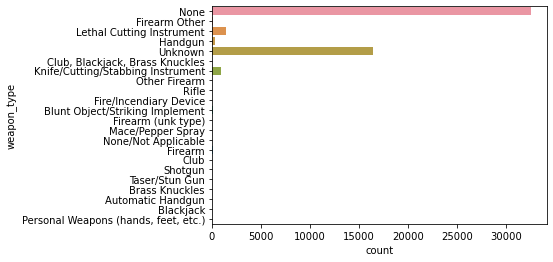

In [92]:
sns.countplot(y='weapon_type', data=df );

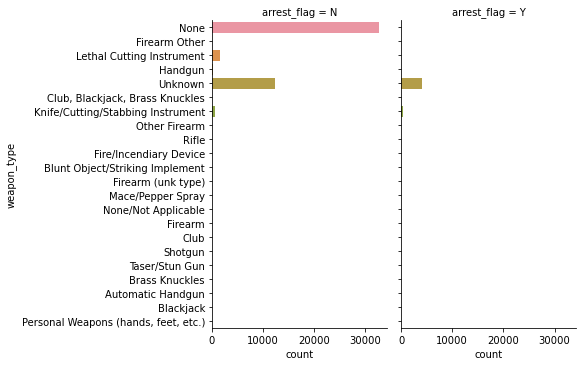

In [93]:
sns.catplot(y='weapon_type', col='arrest_flag', data=df, 
           kind='count', height=5, aspect=.8);

#### Looking at target (arrests/frisk) by age group

In [94]:
df.groupby(['subject_age_group'])['target'].count()

subject_age_group
1 - 17           2057
18 - 25         10298
26 - 35         17432
36 - 45         11253
46 - 55          6714
56 and Above     2692
Unknown          1769
Name: target, dtype: int64

In [95]:
df.groupby(['stop_resolution'])['target'].count()

stop_resolution
Arrest                      12866
Citation / Infraction         189
Field Contact               21983
Offense Report              16449
Referred for Prosecution      728
Name: target, dtype: int64

In [96]:
df.loc[(df['target'] == 'Y') | (df['stop_resolution'] != 'Arrest')]

,subject_age_group,stop_resolution,weapon_type,officer_YOB,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,reported_date,reported_time,arrest_flag,frisk_flag,target
1,Unknown,Field Contact,None,1965,M,White,Unknown,Unknown,2015-03-19T00:00:00Z,07:59:00.0000000,N,N,0
2,Unknown,Field Contact,None,1961,M,White,White,Male,2015-03-21T00:00:00Z,19:12:00.0000000,N,Unknown,0
3,Unknown,Field Contact,None,1963,M,White,Unknown,Unknown,2015-04-01T00:00:00Z,04:55:00.0000000,N,N,0
4,Unknown,Field Contact,None,1977,M,White,Black or African American,Male,2015-04-03T00:00:00Z,00:41:00.0000000,N,N,0
5,Unknown,Field Contact,None,1973,M,White,Black or African American,Male,2015-04-05T00:00:00Z,23:46:00.0000000,N,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52209,56 and Above,Field Contact,Unknown,1997,F,White,White,Male,2020-10-18T00:00:00Z,11:30:04.0000000,N,N,0
52210,56 and Above,Offense Report,Unknown,1989,M,White,White,Male,2021-11-05T00:00:00Z,02:10:13.0000000,N,N,0
52211,56 and Above,Field Contact,Unknown,1992,M,White,White,Male,2022-06-30T00:00:00Z,22:18:57.0000000,N,N,0
52212,56 and Above,Field Contact,Unknown,1994,M,Two or More Races,Unknown,Male,2022-07-04T00:00:00Z,18:43:11.0000000,N,N,0


In [ ]:
# can I break this up by race?
# df.groupby[('subject_perceived_race')] | [(df['target'] == 'Y') | (df['stop_resolution'] != 'Arrest')].count()

In [43]:
class SpecialTransformer(BaseEstimator):
    pass

my_special_trans = SpecialTransformer()
my_special_trans
# creating the base estimator

SpecialTransformer()

In [ ]:
class SpecialTransformer(BaseEstimator):
    def fit(self, X, y=None):
        self.max_

In [10]:
X = df.drop(columns = ['Arrest Flag', 'Frisk Flag', 'Target'])
y = df['Target']

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34984 entries, 20971 to 15795
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         34984 non-null  object
 1   Subject ID                34984 non-null  int64 
 2   GO / SC Num               34984 non-null  int64 
 3   Terry Stop ID             34984 non-null  int64 
 4   Stop Resolution           34984 non-null  object
 5   Weapon Type               34984 non-null  object
 6   Officer ID                34984 non-null  object
 7   Officer YOB               34984 non-null  int64 
 8   Officer Gender            34984 non-null  object
 9   Officer Race              34984 non-null  object
 10  Subject Perceived Race    34984 non-null  object
 11  Subject Perceived Gender  34984 non-null  object
 12  Reported Date             34984 non-null  object
 13  Reported Time             34984 non-null  object
 14  Initial Call Type 

In [12]:
X_train.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

In [13]:
X_train.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,3.498400e+04,3.498400e+04,3.498400e+04,34984.000000
mean,3.901400e+09,2.017916e+13,6.116925e+09,1983.414532
std,6.876814e+09,1.097517e+11,9.823377e+09,9.041369
min,-1.000000e+00,-1.000000e+00,2.802000e+04,1900.000000
25%,-1.000000e+00,2.016000e+13,2.033028e+05,1979.000000
50%,-1.000000e+00,2.018000e+13,4.426245e+05,1985.000000
75%,7.729671e+09,2.019000e+13,1.210470e+10,1990.000000
max,3.495230e+10,2.022000e+13,3.496385e+10,2000.000000


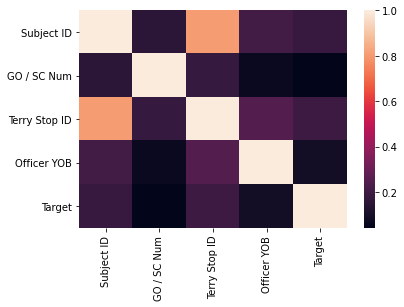

In [106]:
sns.heatmap(df.corr());

## Data Processing

In [14]:
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'O']

len(cat_cols)
# grabbing the categorical columns

17

In [21]:
X_train.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [22]:
num_cols = [
    'Subject ID',
    'GO / SC Num',
    'Terry Stop ID',
    'Officer YOB'
]
len(num_cols)

4

In [23]:
used_cols = [*cat_cols, *num_cols]
used_cols
# unpacks lists, and creats one giant list

['Subject Age Group',
 'Stop Resolution',
 'Weapon Type',
 'Officer ID',
 'Officer Gender',
 'Officer Race',
 'Subject Perceived Race',
 'Subject Perceived Gender',
 'Reported Date',
 'Reported Time',
 'Initial Call Type',
 'Final Call Type',
 'Call Type',
 'Officer Squad',
 'Precinct',
 'Sector',
 'Beat',
 'Subject ID',
 'GO / SC Num',
 'Terry Stop ID',
 'Officer YOB']

In [33]:
cat_transformer = OneHotEncoder(drop = 'first', handle_unknown='error')

num_transformer = StandardScaler()

In [34]:
preprocessor = ColumnTransformer([
 ('cats', cat_transformer, cat_cols),
 ('nums', num_transformer, num_cols)
])

## Initial Modeling

### Model-less Baseline

In [37]:
df['Weapon Type'].value_counts()

None                                    32565
Unknown                                 16475
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         886
Handgun                                   331
Blunt Object/Striking Implement           116
Firearm Other                             100
Firearm                                    59
Club, Blackjack, Brass Knuckles            49
Mace/Pepper Spray                          40
Other Firearm                              38
Firearm (unk type)                         15
Taser/Stun Gun                             12
Fire/Incendiary Device                     11
None/Not Applicable                         9
Club                                        9
Rifle                                       8
Shotgun                                     4
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Blackjack                                   1
Brass Knuckles                    

In [ ]:
clean_list = []
for cell in df['Weapon Type']:
    print(cell.lower())
    if ('gun' in cell.lower()) or ('firearm' in cell.lower()):
        print('firearm')
    else:
        print('None')

In [31]:
pd.Seri`es(y_train).value_counts(normalize=True)

0    0.713698
1    0.286302
Name: Target, dtype: float64

### Evaluate:
- If we predict that an arrest did not happen, we'd be right about 71% of the time.
- Class imbalance

### Model 1: Decision Tree

In [35]:
clf_dt = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('tree', DecisionTreeClassifier(
 random_state=42, max_depth=10))
])

clf_dt.fit(X_train[used_cols],y_train)

train_preds = clf_dt.predict(X_train[used_cols])
test_preds = clf_dt.predict(X_test[used_cols])

train_probas = clf_dt.predict_proba(X_train[used_cols])[:,1]
test_probas = clf_dt.predict_proba(X_test[used_cols])[:,1]

ValueError: Found unknown categories ['Blackjack'] in column 2 during transform